In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

# import gpumap
from c3linearize import linearize, class_graph
from adjustText import adjust_text

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.op.analysis import Run_Manager

from sklearn.decomposition import PCA
import sklearn.datasets

from src import sample_full_interventions, response_mat, conditioned_reponses


In [2]:
save_figure_kwargs = dict(
    root = r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\n21_supplement',
    exts = ['png', 'pdf'],
)

def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    

info = util.adict()

info.fsize = (9,6)

info.cut = 'eval'
info.cut = 'final'

info.device = 'cuda:1'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {n:f'C{n}' for n in range(10)}
info.group_names = {1:'Baseline', 0: 'Structural', 3:'Ladder', 2:'Adaptive', }

preset_figure_info(info)
print(info)

t{fsize, cut, device, results_name, small_font_size, medium_font_size, large_font_size, colors, group_names}


In [3]:
raw = '''AE	3ds_ae0_e-c12_d-c12_mish_210125-050038	toy_ae_e-c12_d-c12_mish_210125-222234	sim_ae_e-c12_d-c12_mish_210126-035850	real_ae_e-c12_d-c12_mish_210126-035928	celeba_ae0_e-c16_d-c16_mish_210125-132401	rfd_ae_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-213908
VAE1	3ds_vae1_e-c12_d-c12_mish_210125-140254	toy_vae1_e-c12_d-c12_mish_210126-122537	sim_vae1_e-c12_d-c12_mish_210126-123641	real_vae1_e-c12_d-c12_mish_210126-123340	celeba_vae1_e-c16_d-c16_mish_210125-132401	rfd_vae1_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214205
VAE2	3ds_vae2_e-c12_d-c12_mish_210125-140255	toy_vae2_e-c12_d-c12_mish_210126-122537	sim_vae2_e-c12_d-c12_mish_210126-123642	real_vae2_e-c12_d-c12_mish_210126-123340	celeba_vae2_e-c16_d-c16_mish-lrp0003_210201-101817	rfd_vae2_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214633
VAE4	3ds_vae4_e-c12_d-c12_mish_210125-140302	toy_vae4_e-c12_d-c12_mish_210127-231812	sim_vae4_e-c12_d-c12_mish_210127-231257	real_vae4_e-c12_d-c12_mish_210127-231852	celeba_vae4_e-c16_d-c16_mish-lrp0004_210201-101817	
VAE8	3ds_vae8_e-c12_d-c12_mish_210125-140550	toy_vae8_e-c12_d-c12_mish_210127-231816	sim_vae8_e-c12_d-c12_mish_210127-231257	real_vae8_e-c12_d-c12_mish_210127-231853		
WAE10	3ds_wae10_e-c12_d-c12_mish_210125-140253	toy_wae10_e-c12_d-c12_mish_210126-122537	sim_wae10_e-c12_d-c12_mish_210126-123641	real_wae10_e-c12_d-c12_mish_210126-123340	celeba_wae10_e-c16_d-c16_mish_210201-000430	rfd_wae10_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-215009
WAE100	3ds_wae100_e-c12_d-c12_mish_210125-221143	toy_wae100_e-c12_d-c12_mish_210126-122537	sim_wae100_e-c12_d-c12_mish_210126-123641	real_wae100_e-c12_d-c12_mish_210126-123340		
WAE1000	3ds_wae1000_e-c12_d-c12_mish_210125-221142	toy_wae1000_e-c12_d-c12_mish_210126-122537	sim_wae1000_e-c12_d-c12_mish_210126-123641	real_wae1000_e-c12_d-c12_mish_210126-123339		
AE S2	3ds_ae_e-c12_d-s2_mish_210131-150237	toy_ae_e-c12_d-s2_mish_210127-231820	sim_ae_e-c12_d-s2_mish_210127-231304	real_ae_e-c12_d-s2_mish_210127-231829		
AE S2 nosplit	3ds_ae_e-c12_d-s2_nosplit-mish_210131-150234	toy_ae_e-c12_d-s2_nosplit-mish_210131-150234	sim_ae_e-c12_d-s2_nosplit-mish_210127-231312	real_ae_e-c12_d-s2_nosplit-mish_210131-150234		
AE S3	3ds_ae_e-c12_d-s3_mish_210201-021841	toy_ae_e-c12_d-s3_mish_210127-231823	sim_ae_e-c12_d-s3_mish_210127-231307	real_ae_e-c12_d-s3_mish_210127-231829		
AE S3 nosplit	3ds_ae_e-c12_d-s3_nosplit-mish_210131-150234	toy_ae_e-c12_d-s3_nosplit-mish_210131-150236	sim_ae_e-c12_d-s3_nosplit-mish_210127-231312	real_ae_e-c12_d-s3_nosplit-mish_210131-150234		
AE S4	3ds_ae0_e-c12_d-s4_mish_210125-140253	toy_ae_e-c12_d-s4_mish_210126-122536	sim_ae_e-c12_d-s4_mish_210127-231308	real_ae_e-c12_d-s4_mish_210126-123339		
AE S4 nosplit	3ds_ae_e-c12_d-s4_nosplit-mish_210131-150234	toy_ae_e-c12_d-s4_nosplit-mish_210131-150235	sim_ae_e-c12_d-s4_nosplit-mish_210127-231315	real_ae_e-c12_d-s4_nosplit-mish_210131-150234		
AE S6	3ds_ae0_e-c12_d-s6_mish_210125-140253	toy_ae_e-c12_d-s6_mish_210126-122536	sim_ae_e-c12_d-s6_mish_210127-231308	real_ae_e-c12_d-s6_mish_210126-123339		
AE S6 nosplit	3ds_ae_e-c12_d-s6_nosplit-mish_210131-150234	toy_ae_e-c12_d-s6_nosplit-mish_210131-150236	sim_ae_e-c12_d-s6_nosplit-mish_210127-231313	real_ae_e-c12_d-s6_nosplit-mish_210131-150236		
AE S12	3ds_ae0_e-c12_d-s12_mish_210125-050335	toy_ae_e-c12_d-s12_mish_210125-222233	sim_ae_e-c12_d-s12_mish_210126-035851	real_ae_e-c12_d-s12_mish_210127-231831	celeba_ae0_e-c16_d-s16_mish_210125-132401	rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256_210524-161708
AE S12 nosplit	3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236	toy_ae_e-c12_d-s12_nosplit-mish_210131-150234	sim_ae_e-c12_d-s12_nosplit-mish_210127-231314	real_ae_e-c12_d-s12_nosplit-mish_210127-231851	celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401	rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256-nosplit_210525-122527
VAE1 L2	3ds_vae1_e-l2_d-l2_mish_210131-150235	toy_vae1_e-l2_d-l2_mish_210131-150234	sim_vae1_e-l2_d-l2_mish_210131-150238	real_vae1_e-l2_d-l2_mish_210131-150240		
VAE1 L3	3ds_vae1_e-l3_d-l3_mish_210131-150235	toy_vae1_e-l3_d-l3_mish_210131-150234	sim_vae1_e-l3_d-l3_mish_210131-150236	real_vae1_e-l3_d-l3_mish_210131-150236		
VAE1 L4	3ds_vae1_e-l4_d-l4_mish_210125-134914	toy_vae1_e-l4_d-l4_mish_210131-150235	sim_vae1_e-l4_d-l4_mish_210127-231449	real_vae1_e-l4_d-l4_mish_210131-150236		
VAE1 L6	3ds_vae1_e-l6_d-l6_mish_210125-140021	toy_vae1_e-l6_d-l6_mish_210131-150235	sim_vae1_e-l6_d-l6_mish_210127-231447	real_vae1_e-l6_d-l6_mish_210131-150236		
VAE1 L12	3ds_vae1_e-l12_d-l12_mish_210125-140249	toy_vae1_e-l12_d-l12_mish_210131-150237	sim_vae1_e-l12_d-l12_mish_210127-231450	real_vae1_e-l12_d-l12_mish_210127-231847	celeba_vae1_e-l16_d-l16_mish-lrp0004_210201-034237	rfd_vae1_e-l16_d-l16_d16-strd-trans-lrp00005-bs64-ch256_210524-214809'''

model_tbl = [row.split('\t') for row in raw.split('\n')]
headers = ['Name', '3D-Shapes', 'CelebA', 'MPI3D Toy', 'MPI3D Sim', 'MPI3D Real', 'RFD']
dataset_names = headers[1:]
all_model_names = {ds:{} for ds in dataset_names}
for title, *names in model_tbl:
    for path, ds in zip(names, dataset_names):
        if path is not None and len(path):
            all_model_names[ds][title] = path
print(tabulate(model_tbl, headers=headers))
len(model_tbl)

Name            3D-Shapes                                      CelebA                                         MPI3D Toy                                      MPI3D Sim                                       MPI3D Real                                          RFD
--------------  ---------------------------------------------  ---------------------------------------------  ---------------------------------------------  ----------------------------------------------  --------------------------------------------------  ---------------------------------------------------------------------------
AE              3ds_ae0_e-c12_d-c12_mish_210125-050038         toy_ae_e-c12_d-c12_mish_210125-222234          sim_ae_e-c12_d-c12_mish_210126-035850          real_ae_e-c12_d-c12_mish_210126-035928          celeba_ae0_e-c16_d-c16_mish_210125-132401           rfd_ae_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-213908
VAE1            3ds_vae1_e-c12_d-c12_mish_210125-140254        toy_vae1_e-c12_d-c

23

In [4]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\final')
root = Path(r'C:\Users\anwan\Documents\workspace\rfd_models')
device = 'cuda'

In [5]:
base_codes = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'VAE2', 'VAE4':'VAE4', 'VAE8':'VAE8', 'WAE10':'WAE1', 'WAE100':'WAE2', 'WAE1000':'WAE3', 
               'AE S2':'S2', 'AE S3':'S3', 'AE S4':'S4', 'AE S6':'S6', 'AE S12':'S12', 
               'VAE1 L2':'L2', 'VAE1 L3':'L3', 'VAE1 L4':'L4', 'VAE1 L6':'L6', 'VAE1 L12':'L12', 
               'AE S2 nosplit':'S2n', 'AE S3 nosplit':'S3n', 'AE S4 nosplit':'S4n', 'AE S6 nosplit':'S6n', 'AE S12 nosplit':'S12n', 
              }
base_titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'VAE2', 'VAE4':'VAE4', 'VAE8':'VAE8', 'WAE10':'WAE1', 'WAE100':'WAE2', 'WAE1000':'WAE3', 
               'AE S2':'SAE-2', 'AE S3':'SAE-3', 'AE S4':'SAE-4', 'AE S6':'SAE-6', 'AE S12':'SAE-12', 
               'VAE1 L2':'VLAE-2', 'VAE1 L3':'VLAE-3', 'VAE1 L4':'VLAE-4', 'VAE1 L6':'VLAE-6', 'VAE1 L12':'VLAE-12', 
               'AE S2 nosplit':'AdaAE-2', 'AE S3 nosplit':'AdaAE-3', 'AE S4 nosplit':'AdaAE-4', 'AE S6 nosplit':'AdaAE-6', 'AE S12 nosplit':'AdaAE-12', 
              }
title_order_base = ['AE S12', 'AE S6', 'AE S4', 'AE S3', 'AE S2', 
               'VAE1 L12', 'VAE1 L6', 'VAE1 L4', 'VAE1 L3', 'VAE1 L2',
               'AE S12 nosplit', 'AE S6 nosplit', 'AE S4 nosplit', 'AE S3 nosplit', 'AE S2 nosplit',
               'AE', 'VAE1', 'VAE2', 'VAE4', 'VAE8', 'WAE10', 'WAE100', 'WAE1000',
              ]

mytitles = {}

In [9]:
ds = 'CelebA'
dscode = 'celeb'

mytitles = {k:v.replace('12', '16') for k,v in base_titles.items()}
# mytitles['VAE1 L12'] = None

In [6]:
ds = 'RFD'
dscode = 'rfd'

mytitles = {k:v.replace('12', '16') for k,v in base_titles.items()}
# mytitles['VAE1 L12'] = None

In [7]:
ds = '3D-Shapes'
dscode = '3ds'



mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }

In [12]:
ds = 'MPI3D Sim'
dscode = 'sim'

mytitles = {'AE S6 nosplit': None}

In [9]:
ds = 'MPI3D Toy'
dscode = 'toy'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }

In [7]:
ds = 'MPI3D Real'
dscode = 'real'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }

In [7]:
groups = {'AE':1, 'VAE1':1, 'VAE2':1, 'VAE4':1, 'VAE8':1, 'WAE10':1, 'WAE100':1, 'WAE1000':1, 
          'AE S2':0, 'AE S3':0, 'AE S4':0, 'AE S6':0, 'AE S12':0, 
          'VAE1 L2':3, 'VAE1 L3':3, 'VAE1 L4':3, 'VAE1 L6':3, 'VAE1 L12':3, 
          'AE S2 nosplit':2, 'AE S3 nosplit':2, 'AE S4 nosplit':2, 'AE S6 nosplit':2, 'AE S12 nosplit':2}



titles = base_titles.copy()
titles.update(mytitles)

info.title = ds
model_names = {k:v for k,v in all_model_names[ds].items() if titles[k] is not None}

if ds == '3D-Shapes':
    model_names['AE S12'] = '3ds_ae_e-c12_d-s12_mish-seed5_210131-150235'

len(model_names), model_names.keys()

(7,
 dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'AE S12', 'AE S12 nosplit', 'VAE1 L12']))

In [8]:
model_names

{'AE': 'rfd_ae_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-213908',
 'VAE1': 'rfd_vae1_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214205',
 'VAE2': 'rfd_vae2_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214633',
 'WAE10': 'rfd_wae10_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-215009',
 'AE S12': 'rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256_210524-161708',
 'AE S12 nosplit': 'rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256-nosplit_210525-122527',
 'VAE1 L12': 'rfd_vae1_e-l16_d-l16_d16-strd-trans-lrp00005-bs64-ch256_210524-214809'}

In [9]:
runs = Run_Manager(model_names, root=root, override={'device':device}, pbar=tqdm)
run_idents = {r.ident:r for r in runs}
title_order = [t for t in title_order_base if t in run_idents]

  0%|          | 0/7 [00:00<?, ?it/s]

ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"


In [10]:
runs.map(lambda run: run.get_records())
runs.load_results('metrics', safe=True, load_kwargs={'device':device});
runs.load_results(info.cut, load_kwargs={'device':device});

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

rfd_ae_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-213908 failed
rfd_vae1_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214205 failed
rfd_vae2_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214633 failed
rfd_wae10_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-215009 failed
rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256_210524-161708 failed
rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256-nosplit_210525-122527 failed
rfd_vae1_e-l16_d-l16_d16-strd-trans-lrp00005-bs64-ch256_210524-214809 failed


Traceback (most recent call last):
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 151, in map
    out = fn(run)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 179, in <lambda>
    return self.map(lambda run: run.get_results(ident, **load_kwargs), **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\runs.py", line 400, in get_results
    self.results[fixed] = self._load_results(name=ident, path=path, **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\loading.py", line 52, in _load_results
    return torch.load(str(path), **special)
  File "C:\Users\anwan\anaconda3\lib\site-packages\torch\serialization.py", line 579, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\anwan\anaconda3\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\anwan\anacond

  0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
def _load_info(run):
    run.info = run.get_config().pull('info', {})
    run.group = groups[run.ident]
    run.title = titles[run.ident]
    run.code = base_codes[run.ident]
runs.map(_load_info);

  0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
run = runs[0]

In [13]:
obs = run_idents['AE'].get_results(info.cut)['original']
obs.shape

torch.Size([64, 3, 128, 128])

In [76]:
run = run_idents['AE S12']
# run = run_idents['AE S6']
# run = run_idents['AE S4']
# run = run_idents['AE S3']
# run = run_idents['AE S2']


run = run_idents['VAE1 L12']
# # run = run_idents['VAE1 L6']
# # run = run_idents['VAE1 L4']
# # run = run_idents['VAE1 L3']
# # run = run_idents['VAE1 L2']

run = run_idents['VAE1']
# run = run_idents['VAE2']
# # run = run_idents['WAE10']

run = run_idents['AE S12 nosplit']
run = run_idents['AE']
run

INLINE_TIMED_SAE_RUN:rfd_ae_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-213908

In [77]:
model = run.get_model()

Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (norm): GroupNorm(8, 256, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 256, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 256, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): GroupNorm(8, 256, eps=1e-05, affine=True)
        (nonlin): 

Loaded parameters from C:\Users\anwan\Documents\workspace\rfd_models\rfd_ae_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-213908\ckpt200000


In [78]:
model.hybridize_groups = True

In [79]:
model._latent.shape

torch.Size([64, 16])

In [80]:
# with torch.no_grad():
#     util.show_imgs(model.generate_hybrid(16));

<IPython.core.display.Javascript object>


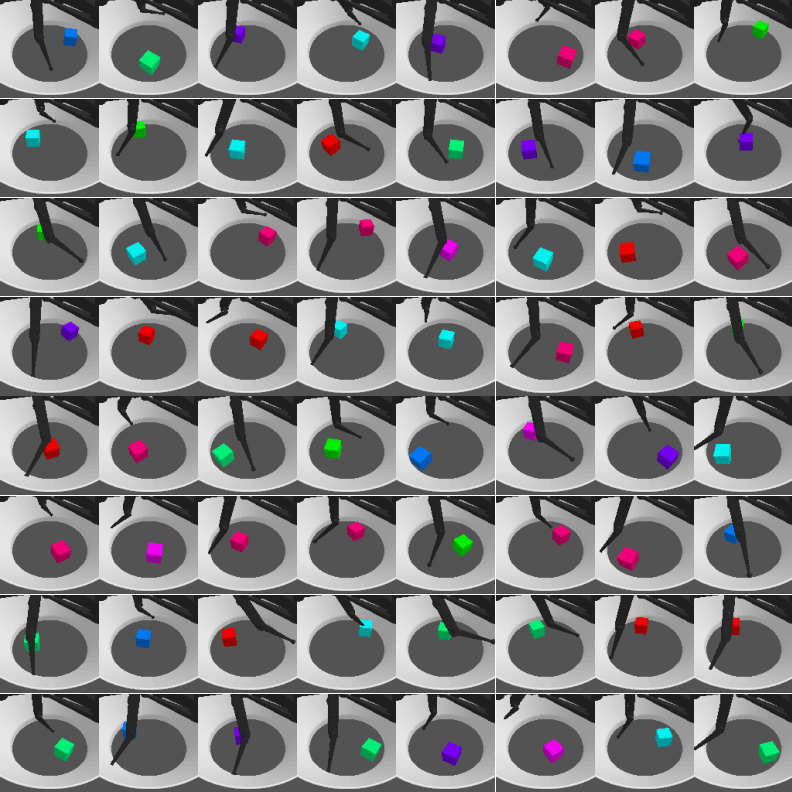

In [81]:
# with torch.no_grad():
#     rec = model(obs)
#     gen = model.generate_hybrid(32)
#     gen = model.generate_prior(32)

util.plot_imgs(obs[:64]);
# util.save_figure(f'{run.code}_original', **save_figure_kwargs)

In [82]:
# q = model._latent.clone()
with torch.no_grad():
    q = model.encode(obs)
    if isinstance(q, distrib.Normal):
        q = q.loc
q.shape

torch.Size([64, 16])

In [83]:

# with torch.no_grad():
#     c = model.decode(q)
    
# util.show_imgs(c[:64]);

In [84]:
# 3ds: 14, 17, 6
# celeb: 0, 11, 21, 25
# mpi: 31, 9, 10

# idx = 14
# idx = 17
# idx = 6

idx = 11
# idx = 25
# idx = 21
# idx = 0

idx = 31
idx = 9
idx = 10

In [85]:
# q = model._latent.clone()
# q.shape

In [86]:
cdim = 8 if dscode == 'celeb' else 3
cdim = 1
cnum = 7
# cnum = 9

In [87]:
cuts_starts = list(q.split(cdim, dim=1))

In [88]:
traverse = True

if traverse:
    def manipulate(qdim):
        mn, mx = qdim.min(0, keepdim=True)[0], qdim.max(0, keepdim=True)[0]
        steps = torch.linspace(0,1,cnum, device=qdim.device).unsqueeze(-1).expand(cnum, qdim.size(-1)).clone()
        deltas = (mx-mn)*steps+mn
        return deltas # traverse
else:
    def manipulate(qdim):
        return util.shuffle_dim(qdim) # shuffle


In [89]:
cs = []
for i, cut in enumerate(cuts_starts):
    cuts = cuts_starts.copy()
    if traverse:
        cuts = [c[idx:idx+1].expand(*cut.size()).clone()[:cnum] for c in cuts]
    else:
        cuts = [c[idx:idx+1].expand(*cut.size()).clone() for c in cuts]
    cuts[i] = manipulate(cut)
    
    qc = torch.cat(cuts, dim=1)
    
    with torch.no_grad():
        c = model.decode(qc)
    
    cs.append(c[:cnum])
cs = torch.stack(cs)
w,h,C,H,W = cs.size()
cs.shape

torch.Size([16, 7, 3, 128, 128])

In [90]:
try:
    num_seg = len(model.decoder.style_dims)
except:
    num_seg = 1
dims_per_seg = cs.shape[0] // num_seg
num_seg, dims_per_seg, cnum

(1, 16, 7)

In [91]:
from torchvision.utils import make_grid

In [92]:
segs = list(cs.view(num_seg, dims_per_seg*cnum, *cs.shape[2:]))
segs = [make_grid(seg, nrow=cnum, padding=1).permute(1,2,0).cpu().numpy() for seg in segs] # .permute(1,2,0)
len(segs), segs[0].shape

(1, (2065, 904, 3))

<IPython.core.display.Javascript object>


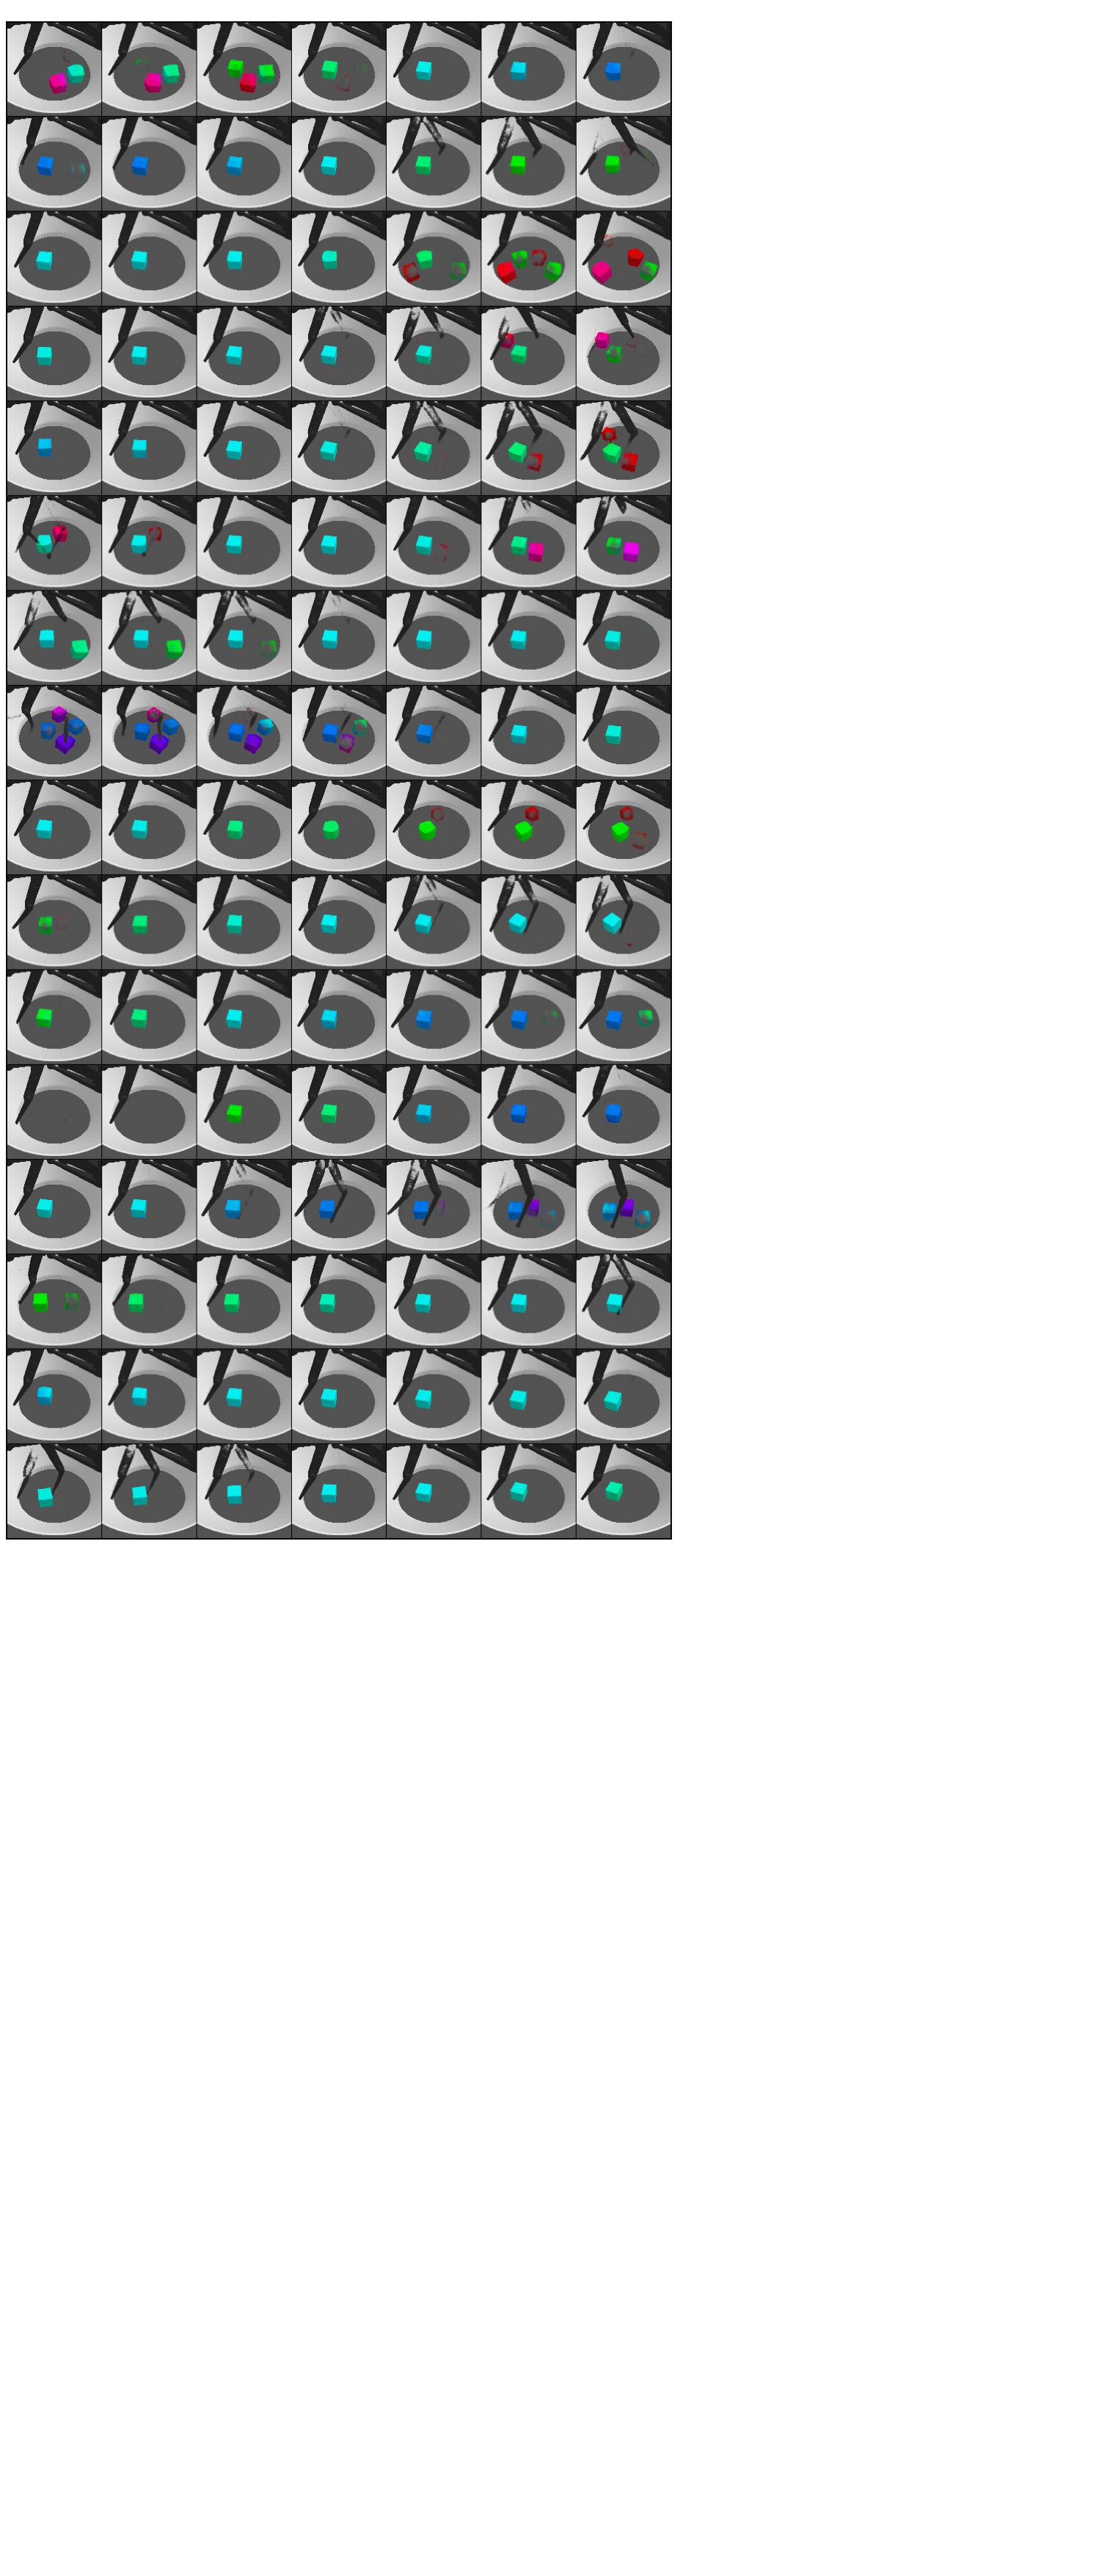

Figure rfd_AE_traversals10 saved as {'pdf', 'png'}


In [93]:
fg, axes = plt.subplots(num_seg, figsize=(cnum*0.8,0.1+w*0.8))
try:
    len(axes)
except:
    axes = axes,

if dscode == 'celeb':
    features = ['Expression', 'Orientation &\nFacial features', 'Hairstyle &\nMinor features', 'Colors/style']
elif dscode in {'toy', 'sim', 'real'}:
    features = ['Position', 'Background &\nCamera', 'Size/Shape', 'Color']

features = []

features = features + ['']*(len(segs))
    
for ax, fea, seg in zip(axes, features, segs):
    plt.sca(ax)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(seg)
    if i == 0:
        plt.ylabel(fea, fontsize=10)
        
# # util.show_imgs(figax=(fg,axes))



# for i, ax in enumerate(axes.flat):
#     plt.sca(ax)
#     plt.axis('on')
# #     plt.xticks([])
# #     plt.yticks([])
# #     if i % 6 == 0:
        
# #         plt.ylabel('test')
# #         plt.title('test')
#     pass
plt.subplots_adjust(hspace=0.04, wspace=0.01, top=0.99, bottom=0.01, left=0.01, right=0.99)
# plt.subplots_adjust(hspace=0.04, wspace=0.01, top=0.99, bottom=0.01, left=0.08, right=0.99)
# plt.tight_layout()
util.save_figure(f'{dscode}_{run.code}_traversals{idx}', **save_figure_kwargs)
pass

In [55]:
ix, iy = 13, 14
ix, iy = 0, 6
dims = [ix, iy]

In [56]:
scales = q.std(0)

In [57]:
qdim = q[...,dims]
(xmn, ymn), (xmx, ymx) = qdim.min(0)[0].tolist(), qdim.max(0)[0].tolist()

In [58]:
@torch.no_grad()
def decode(q):
    return model.decode(q.to(device))

<IPython.core.display.Javascript object>


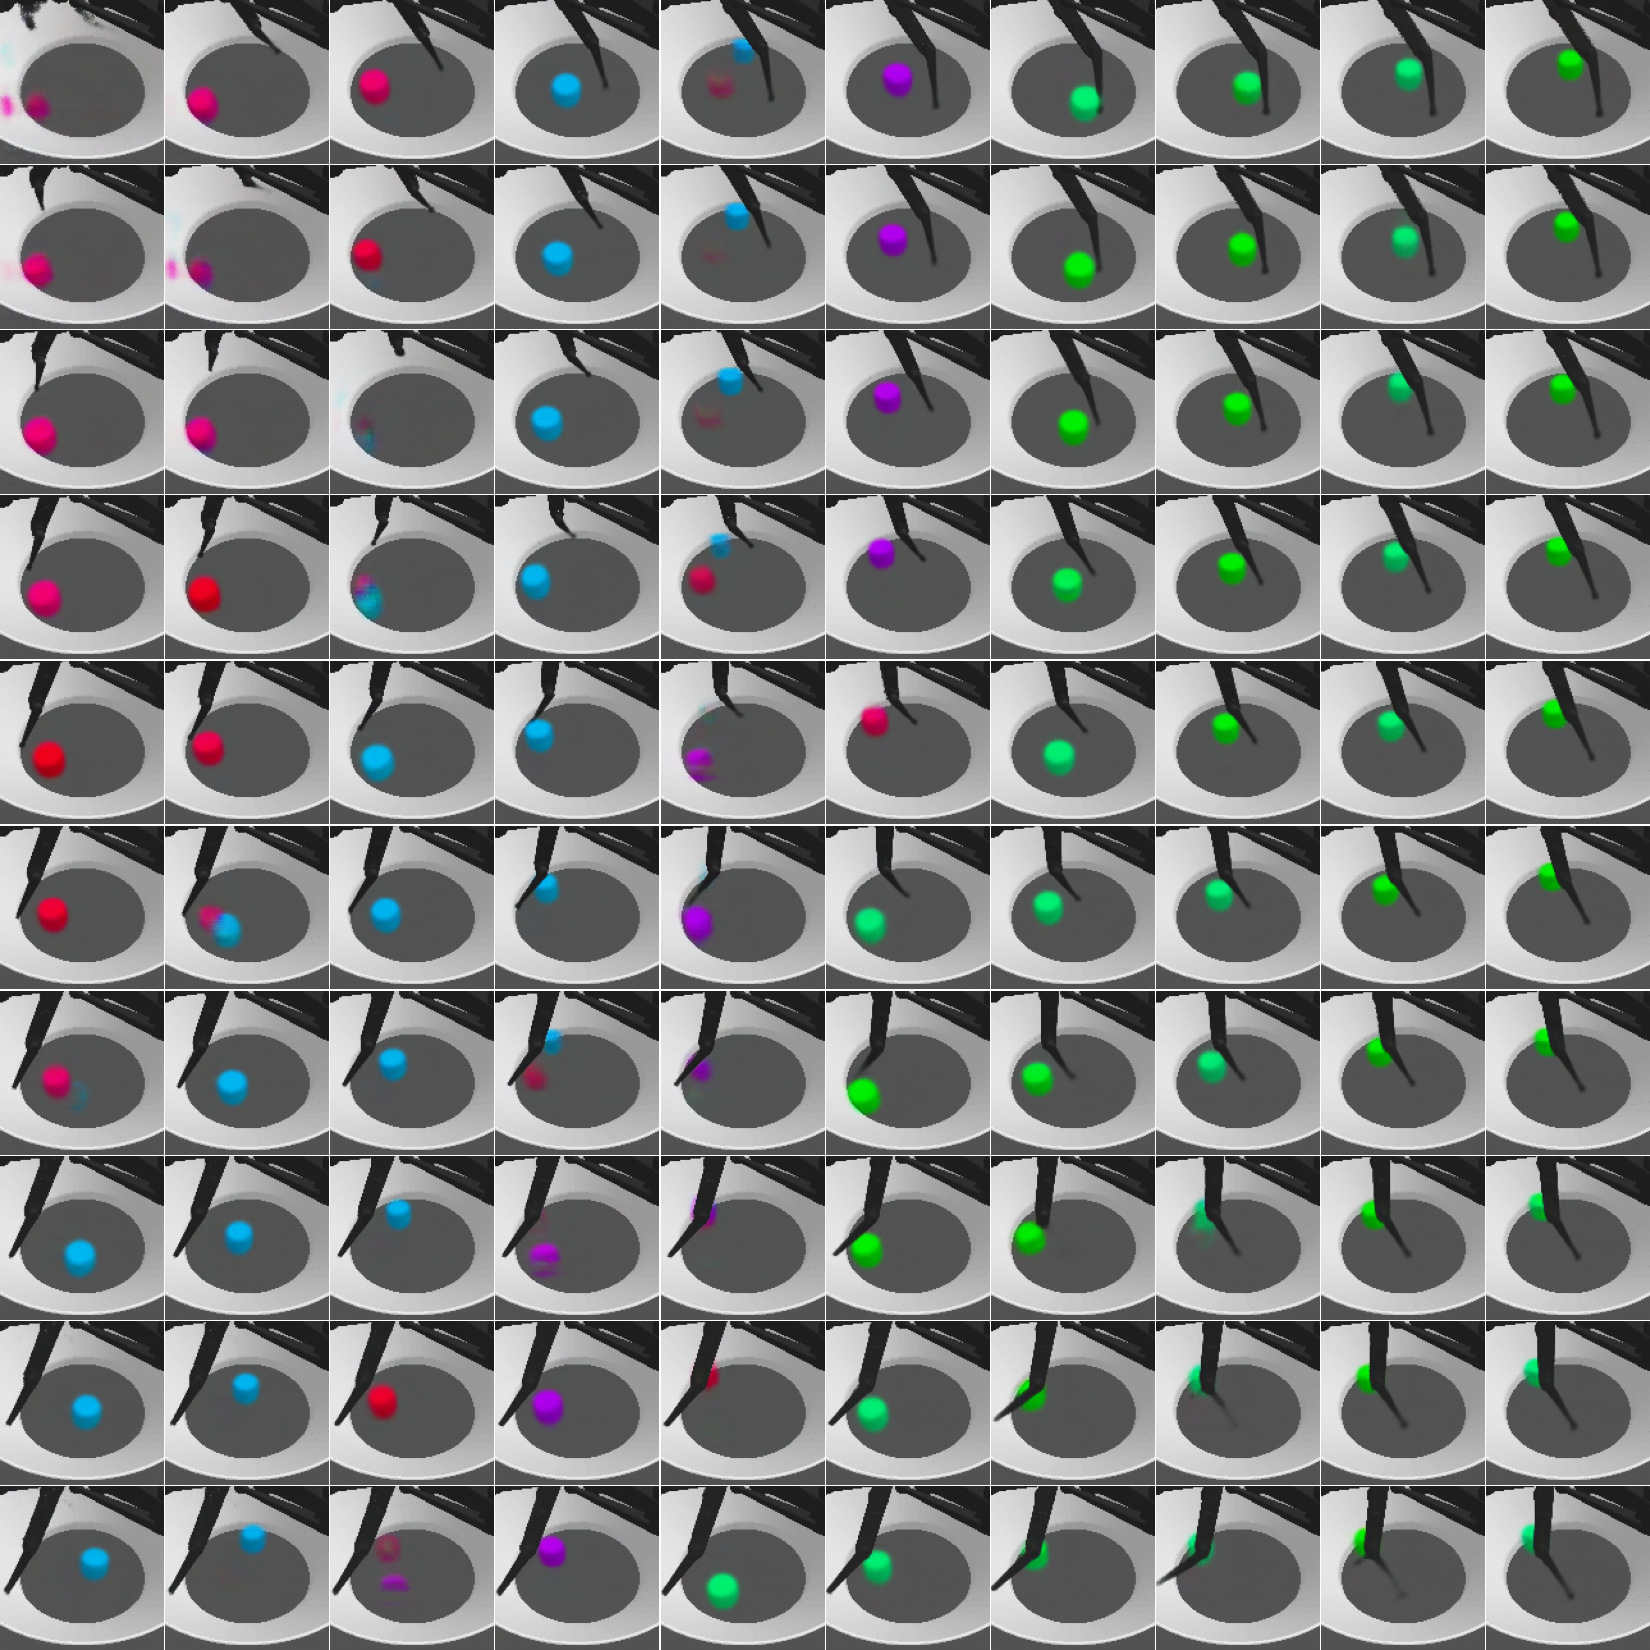

Figure rfd_VAE_2dtraversal10-0-6 saved as {'pdf', 'png'}


In [59]:
n_obs = 10
side = 1
interp_idx = idx

vin = q[interp_idx:interp_idx+1].expand(n_obs**2, -1).contiguous()
vin[:,dims] = torch.stack(torch.meshgrid(torch.linspace(xmn,xmx,n_obs), torch.linspace(ymn,ymx,n_obs)),-1).reshape(-1,2).to(device)
with torch.no_grad():
    intmap = decode(vin).cpu()
imshape = intmap.shape[1:]
intmap = torch.from_numpy(intmap.reshape(n_obs,n_obs,*imshape).permute(1,0,2,3,4).numpy()[::-1].copy()).reshape(n_obs*n_obs,*imshape)
# intmap = intmap.reshape(n_obs,n_obs)
util.plot_imgs(intmap, H=n_obs, params=dict(cmap='Greys'), figsize=(n_obs*side,n_obs*side));
util.save_figure(f'{dscode}_{run.code}_2dtraversal{interp_idx}-{ix}-{iy}', **save_figure_kwargs)
# util.save_figure(f'recs-{ix}-{iy}', **fig_kwargs)